In [38]:
#
# Author: J.G. Messchendorp, October 2020
#
# Code used as demonstrator for supervised machine learning techniques
# and applied to "fruit" data sample
#

%matplotlib inline

import pandas as pd                                  # smart dataFrame for data manipulations
import numpy as np

import requests                                      # used to read data from URL address
from requests.auth import HTTPBasicAuth              # setup authentication of URL 

import matplotlib.pyplot as plt                      # plotting results in a neat way!
from matplotlib.colors import ListedColormap         # ..used for decision surface plots
import matplotlib as mpl

import seaborn as sn                                 # nice for plotting heatmaps, used for correlation matrix

from sklearn import tree                             # classifier decision trees
from sklearn import neighbors                        # classifier kNN
from sklearn.ensemble import RandomForestClassifier  # classifier Random Forest
from sklearn.neural_network import MLPClassifier     # classifier multi-layer perceptron
from random import uniform as random_uniform         # random number generator for randomizing train/test samples

from IPython.core.display import Image               # ...for displaying images in notebook, used for decision tree pictures
from six import StringIO                             # write string buffers as files, used for making decision tree pictures
import re                                            # regular expression operations, needed for making decision tree pictures

import VisualizeNN as VisNN                          # MLP network visualization, requires corresponding python code:
                                                     # http://www.jzliu.net/blog/simple-python-library-visualize-neural-network/
import warnings
from pandas.core.common import SettingWithCopyWarning
warnings.simplefilter(action="ignore", category=SettingWithCopyWarning)

# Update the matplotlib configuration parameters:
mpl.rcParams.update({'font.size': 20, 'font.family': 'serif', 'xtick.major.pad' : 5, 'ytick.major.pad' : 5})

In [39]:
#
# Read the comma-seperated datafile and print first 10 entries
# "data" is of type DataFrame
#

#
# If you want to read the data directly from URL of nestor, uncomment the following three lines:
#

#"https://drive.google.com/file/d/1DvfXahhZMrag420fbdkPGCTN-wUXSQ8B/view?usp=sharing"
#url="https://drive.google.com/uc?export=download&id=1DvfXahhZMrag420fbdkPGCTN-wUXSQ8B"
#s=requests.get(url).content
#data = pd.read_csv(StringIO(s.decode('utf-8')))

data = pd.read_csv('fruit.csv')

#
# Otherwise, in case you installed the file locally:
#

#data = pd.read_csv('fruit.csv')

data.head(10)

,fruitid,fruitname,colorid,colorname,elongatedness,weight,sweetness,acidity
0,1,orange,2,brown,0.14,152,3.56,1095
1,1,orange,2,brown,0.09,167,3.33,1080
2,1,orange,2,brown,0.15,152,4.00,1035
3,1,orange,2,brown,0.03,155,3.00,680
4,1,orange,2,brown,0.08,147,2.69,1020
5,1,orange,2,brown,0.14,147,3.55,1045
6,1,orange,2,brown,0.14,152,3.33,985
7,1,orange,2,brown,0.18,159,2.88,1515
8,1,orange,3,green,0.08,152,3.17,1185
9,1,orange,4,orange,0.18,174,3.03,1120


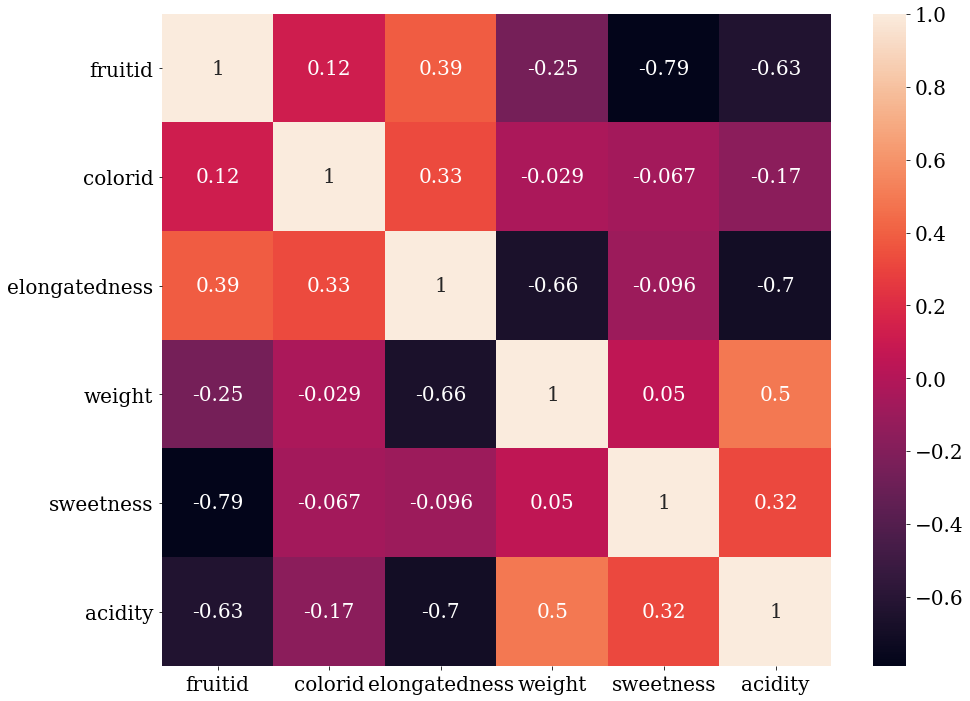

In [40]:
#
# Create correlation matrix among features and labels
# Use seaborn.heatmap to make it look neat!
#
corrMatrix = data.corr()

plt.figure(figsize=(15, 12))
sn.heatmap(corrMatrix, annot=True)
plt.show()

In [41]:
def NormalizeData(data, feature_list):
    """
    Normalize features in "feature_list" of dataFrame "data".
    New features will be added as columns to the dataFrame with label "_normal".
    The function returns the updated table.
    """
    
    # Dont modify the original dataFrame "data"
    data_tmp = data.copy()

    # Run over all features and create new column with "_normal"
    for feature in feature_list:
        feature_new = feature + "_normal"
        data_tmp[feature_new] = (data_tmp[feature] - data_tmp[feature].mean()) / data_tmp[feature].std()

    # Return the updated dataFrame
    return data_tmp

In [42]:
#
# Normalize some of the features and create new columns with normalized values:
#
data = NormalizeData(data,['weight','sweetness','acidity','elongatedness'])
#
# Check that the average = 0 and std = 1 for the normalized numbers:
#
data[['weight_normal', 'sweetness_normal', 'acidity_normal','elongatedness_normal']].describe()

,weight_normal,sweetness_normal,acidity_normal,elongatedness_normal
count,1.790000e+02,1.790000e+02,1.790000e+02,1.790000e+02
mean,-5.954269e-16,3.969512e-17,-1.587805e-16,7.939025e-17
std,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
min,-2.040430e+00,-1.876399e+00,-1.488391e+00,-1.706801e+00
25%,-7.956576e-01,-9.564810e-01,-7.789503e-01,-9.039453e-01
50%,-6.954036e-02,2.443281e-01,-2.349399e-01,-1.010901e-01
75%,6.047114e-01,7.920656e-01,7.608219e-01,8.252814e-01
max,2.783063e+00,1.957763e+00,2.971859e+00,2.430992e+00


In [43]:
#
# The engine code behind the ML algorithm used in this example.
# We make use of classifier "classifier":
#

def Classify(classifier, data, params,
             prop_test=0.3, feature_list=['acidity','sweetness'], 
             plot_ds=False, plot_tree=False, plot_network=False):
    """
    Use "classifier" algorithm to classify dataset data. Use feature list feature_list
    and use prop_test fraction of the data as test sample, rest for training.
    The function returns an updated dataset including a column with predicted class.
    """
    
    assert 0<prop_test<1
     
    #
    # make a copy of the dataframe. The original table will not be altered.
    #
    data_tmp = data.copy()
    #
    # Add a column specifying whether event is used for training or for testing
    #
    data_tmp['is_train'] = np.random.uniform(0, 1, len(data_tmp)) <= (1-prop_test)
    #
    # Extract two seperate datasets for training (train) and testing (test)
    #
    train, test = data_tmp[data_tmp['is_train']==True], data_tmp[data_tmp['is_train']==False]
    
    
    if   (classifier=="DT"):
        # we create an instance of Decision Tree Classifier.
        clf = tree.DecisionTreeClassifier(criterion='entropy',
                                          min_impurity_decrease=params[0],
                                          max_depth=params[1])
    elif (classifier=="RF"):
        # we create an instance of Random Forest Classifier.
        clf = RandomForestClassifier(n_estimators=params[0], 
                                     max_features=params[1])
    elif (classifier=="kNN"):
        # we create an instance of kNN Classifier.
        clf = neighbors.KNeighborsClassifier(n_neighbors=params[0])
    elif (classifier=="MLP"):
        # we create an instance of MLP Classifier.
        clf = MLPClassifier(solver='lbfgs', activation='logistic', #solver=quasi-Newton, activation=sigmoid
                            max_iter=5000, 
                            hidden_layer_sizes=params[0])
    else:
        print("<E> Classifier not implemented: ", classifier)
        return None
    
    # Fit the data with the selected classifier...
    clf.fit(train[feature_list],train['fruitid'])
    
    #evaluate the training points
    trainpred = clf.predict(train[feature_list]) # majority vote result
    train['prediction'] = [x for x in trainpred]
   
    # Predict on the testing points       
    testpred = clf.predict(test[feature_list])   # majority vote result
    test['prediction'] = [x for x in testpred]
 
    data_update = train.append(test)
     
    # Make it possible to plot the decision surface if plot_ds flag set to True and nr of features equals 2.
    if (plot_ds) & (len(feature_list)==2):
        PlotDecisionSurface(clf,data_update,feature_list)

    # In the case the classifier is a decision tree, allow for the possibility to plot the tree, 
    # only when plot_tree is set to True.
    if (plot_tree) & (classifier=="DT"): 
        PlotTree(clf, feature_list)
  
    # Plot the network structure in case of multi-layer perceptron
    # Only when plot_network flag is set to True. Comment out if VisNN code not available!
    if (plot_network) & (classifier=="MLP"):   
        network_structure = np.hstack(([len(feature_list)], np.asarray(clf.hidden_layer_sizes), [data['fruitid'].nunique()]))
        # Draw the Neural Network with weights given by clf.coefs_
        network=VisNN.DrawNN(network_structure, clf.coefs_)
        network.draw()
            
    # Return the updated version of the dataFrame including labels "is_train" and "predicted".
    return data_update

#
# GetNrOfSuccesses(dataFrame): returns fraction of succesfull classifications for training and test 
#                              part of the data table and used as the metric for the fruit analysis!
#

def GetNrOfSuccesses(data):
    """
    Reads as input DataFrame "data" and return the fraction of successfull classifications of
    the training and test part of the table. This function only works with an updated DataFrame
    that includes the columns "is_train" and "prediction", generated by Classify() function.
    """
    
    nrtrain_instances = len(data[(data.is_train == True)])
    nrtest_instances  = len(data[(data.is_train == False)])
    
    nrtrain_success = len(data[(data.is_train == True)  & (data.prediction == data.fruitid)])
    nrtest_success  = len(data[(data.is_train == False) & (data.prediction == data.fruitid)])
    
    return (nrtrain_success/nrtrain_instances), (nrtest_success/nrtest_instances)

#
# PlotTree: a procedure that displays the tree structure of classifier clf...
#

def PlotTree(clf, feature_list):
    """
    Plot the decision tree of classifier "clf" with list of features given in "feature_list".
    The function creates a file called "simple.dotfile" and corresponding "simpletree.png".
    To generate the png-file, "dot" needs to be installed on your OS.
    The png-file is displayed in the notebook.
    """
    dot_data = StringIO() 
    tree.export_graphviz(clf, out_file=dot_data)
    tree_string = dot_data.getvalue()
    tree_string = re.sub('samples = [0-9]+\\\\n', '', tree_string) # Remove line starting with samples = ...
    for i, feature in enumerate(feature_list):
        tree_string = re.sub('X\[{}\]'.format(i), feature, tree_string) # Replace X[..] with true feature name
    with open('simple.dotfile', 'w+') as f:
        f.write(tree_string)
    !dot -Tpng simple.dotfile > simpletree.png  # "dot" needs to be installed on your OS; see info https://graphviz.org/documentation/ 
    display(Image(filename ='simpletree.png'))
    return  

#
# PlotDecisionSurface: function that creates decision surface based on classifier clf
# and features in feature_list of dataFrame data. It uses "meshgrid" of numpy to generate
# grid of points to evaluate by classifier. For plotting, it uses "pcolormesh" of matplotlib.
#

def PlotDecisionSurface(clf, data, feature_list, label='fruitid', step=0.01):
    """
    Function that creates a decision surface of classifier "clf"
    together with features from the two entries of the "features_list" of "data"
    """
    X = data[feature_list[0]].values
    Y = data[feature_list[1]].values
    
    # colors associated with the three classes, light is used for surface and bold for datapoints
    cmap_light = ListedColormap(['#ffde9e', '#b8ea9d', '#ffbaba'])
    cmap_bold  = ListedColormap(['#ff8c28', '#11bb11', '#ff0000'])
    
    # Plot the decision boundary. For that, we will assign a color to each
    # point in the mesh [x_min, m_max] x [y_min, y_max].
    x_min, x_max = X.min(), X.max()
    y_min, y_max = Y.min(), Y.max()
    xx, yy = np.meshgrid(np.arange(x_min, x_max, step),
                         np.arange(y_min, y_max, step))
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    
    # Put the result into a color plot
    plt.figure(figsize=(10, 8))
    plt.pcolormesh(xx, yy, Z, cmap=cmap_light, shading='auto')
    # Plot the data points
    plt.scatter(X, Y, s=40, c=data[label], cmap=cmap_bold)
    plt.xlim(x_min, x_max)
    plt.ylim(y_min, y_max)
    plt.xlabel(feature_list[0])
    plt.ylabel(feature_list[1])
    plt.show()
    return

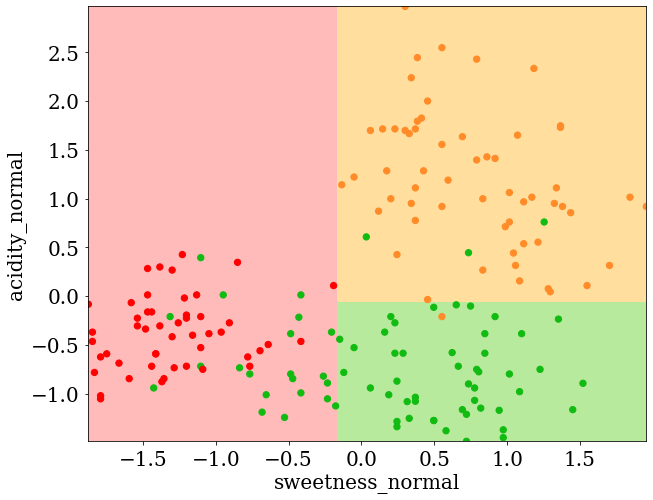

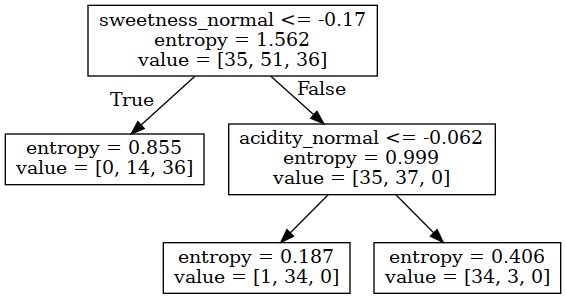

Success rate:  0.8524590163934426 0.8771929824561403


In [56]:
#
# Let's test Classify function for a decision tree, and see what it creates ;-)
#
classifier            = 'DT'
min_impurity_decrease = 0.3
max_depth             = None
params                = [min_impurity_decrease, max_depth]
prop_test             = 0.3
feature_list          = ['sweetness_normal', 'acidity_normal'] #Q: do you really have to use _normal features?
plot_ds               = True
plot_tree             = True
plot_network          = False

data_new = Classify(classifier=classifier, data=data, params=params, prop_test=prop_test, feature_list=feature_list, 
                    plot_ds=plot_ds, plot_tree=plot_tree, plot_network=plot_network)

train_success, test_success = GetNrOfSuccesses(data_new)
print('Success rate: ', train_success, test_success)

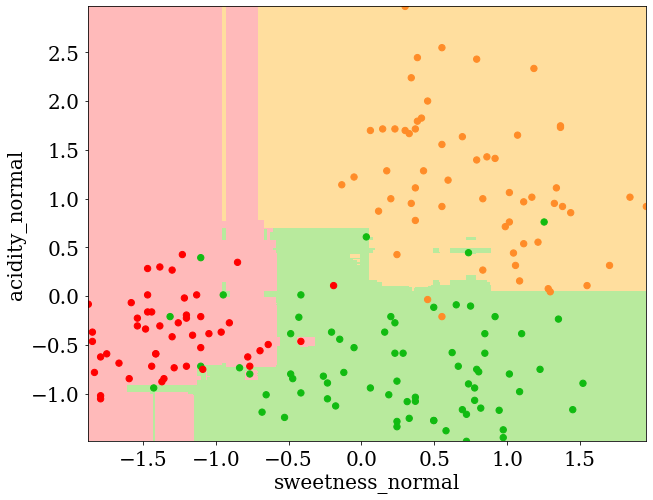

Success rate:  1.0 0.8269230769230769


In [59]:
#
# Let's test Classify function for a Random Forest, and see what it creates ;-)
#
classifier            = 'RF'
n_estimators          = 1000
max_features          = 'auto'
params                = [n_estimators,max_features]
prop_test             = 0.3
feature_list          = ['sweetness_normal', 'acidity_normal']
plot_ds               = True
plot_tree             = False
plot_network          = False

data_new = Classify(classifier=classifier, data=data, params=params, prop_test=prop_test, feature_list=feature_list, 
                    plot_ds=plot_ds, plot_tree=plot_tree, plot_network=plot_network)

train_success, test_success = GetNrOfSuccesses(data_new)
print('Success rate: ', train_success, test_success)

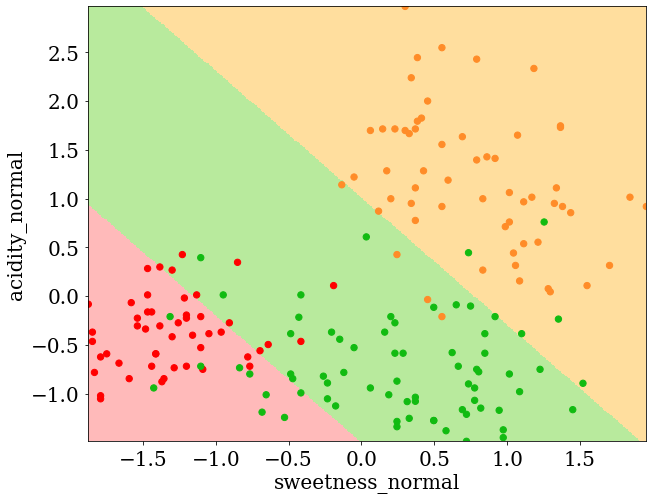

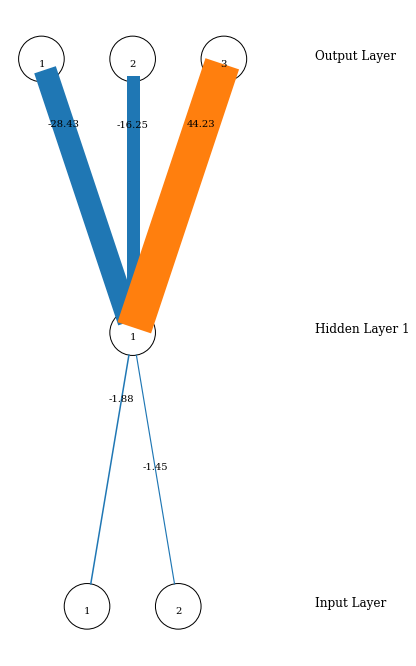

Success rate:  0.8608695652173913 0.8125


In [33]:
#
# Let's test Classify function for a multi-layer perceptron, and see what it creates ;-)
#
classifier            = 'MLP'
hidden_layers         = (1)
params                = [hidden_layers]
prop_test             = 0.3
feature_list          = ['sweetness_normal', 'acidity_normal']
plot_ds               = True
plot_tree             = False
plot_network          = True

data_new = Classify(classifier=classifier, data=data, params=params, prop_test=prop_test, feature_list=feature_list, 
                    plot_ds=plot_ds, plot_tree=plot_tree, plot_network=plot_network)

train_success, test_success = GetNrOfSuccesses(data_new)
print('Success rate: ', train_success, test_success)

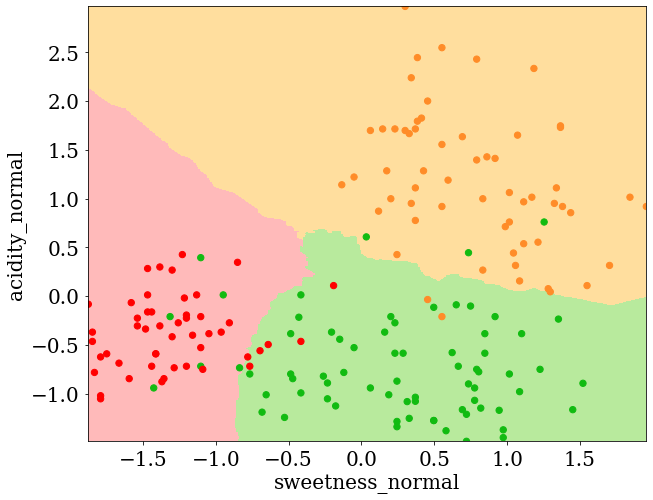

Success rate:  0.8863636363636364 0.9574468085106383


In [10]:
#
# Let's test Classify function for kNN, and see what it creates ;-)
#
classifier            = 'kNN'
n_neighbours          = 30
params                = [n_neighbours]
prop_test             = 0.3
feature_list          = ['sweetness_normal', 'acidity_normal']
plot_ds               = True
plot_tree             = False
plot_network          = False

data_new = Classify(classifier=classifier, data=data, params=params, prop_test=prop_test, feature_list=feature_list, 
                    plot_ds=plot_ds, plot_tree=plot_tree, plot_network=plot_network)

train_success, test_success = GetNrOfSuccesses(data_new)
print('Success rate: ', train_success, test_success)

In [12]:
#
# Piece of code that performs cross validation and returns for each validation the success rates
#
def ClassifierTest(classifier, data, params, 
                    reps=1, prop_test=0.3, 
                    feature_list=['acidity','sweetness'], 
                    plot_ds=False,
                    plot_tree=False):
    """ 
    Function that performs a classification for classifier "classifier" for "reps" cross validations. 
    It returns the error rate for train and test samples.
    """
    
    assert 0<prop_test<1
      
    train_result = []
    test_result  = []
        
    for rep in range(reps):
      
        dn = Classify(classifier=classifier, data=data, params=params,
                      prop_test=prop_test, feature_list=feature_list, 
                      plot_ds=plot_ds, plot_tree=plot_tree)
        
        success_train, success_test = GetNrOfSuccesses(dn)
        
        train_result.append(success_train)
        test_result.append(success_test)
        
    return [train_result, test_result]

In [15]:
#
# Let's run the classifier test
#

classifier            = 'DT'
min_impurity_decrease = 0
max_depth             = None
params                = [min_impurity_decrease, max_depth]
prop_test             = 0.3
feature_list          = ['sweetness_normal', 'acidity_normal']

ClassifierTest(classifier=classifier, data=data, params=params, prop_test=prop_test, feature_list=feature_list, reps=5)

[[1.0, 1.0, 1.0, 1.0, 1.0],
 [0.8666666666666667,
  0.7045454545454546,
  0.8181818181818182,
  0.8723404255319149,
  0.8235294117647058]]

In [13]:
#
# Try to find the optimum value of "min_impurity_decrease" (mid).
# Hence run the DT_test for several values of "min_impurity_decrease" and study the resulting error rate
#
midlist       = np.arange(0,0.1,0.0025)                                # list of mid-values to study
feature_list  = ['weight_normal','sweetness_normal','acidity_normal']  # list of input features
params        = [0, None]                                              # [min impurity decrease,max_depth]

mid_result = []
for mid in midlist:
    params=[mid, None]
    result = ClassifierTest(classifier='DT', data=data, params=params, reps=100, prop_test=0.3, feature_list=feature_list)
    train_error = 1 - np.mean(result[0]) # take the average of all the cross validations as result
    test_error  = 1 - np.mean(result[1]) # ...same for test samples
    mid_result.append([train_error,test_error])

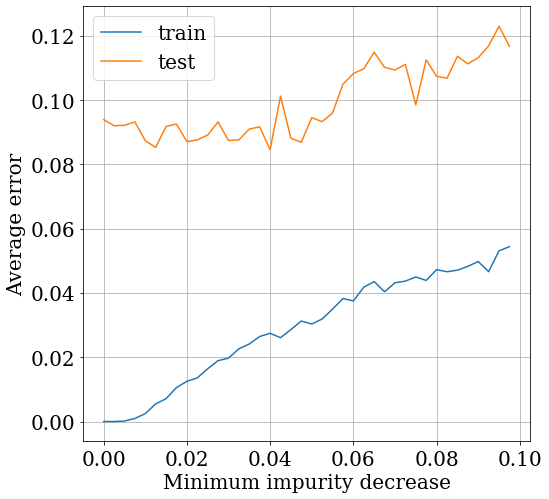

In [16]:
#
# Plot the fraction of classification errors versus "k" for training and test part of the dataset
#
plt.figure(figsize=(8, 8))
plt.plot(midlist, np.transpose(mid_result)[0],label='train')
plt.plot(midlist, np.transpose(mid_result)[1],label='test')
plt.xlabel('Minimum impurity decrease')
plt.ylabel('Average error')
plt.legend(loc='best')
plt.grid(True)
plt.show()

In [17]:
#
# Let's run a performance test among various classifiers...
#

feature_list = ['weight_normal','sweetness_normal','acidity_normal'] 

params_RF  = [100, 'auto']  # [n_estimators, max_features]
params_DT  = [0.04, None]   # [min_impurity_decrease, max_depth]
params_kNN = [30]           # [n_neighbors]
params_MLP = [(2,)]         # [hidden_layer_sizes]

RF_result  = ClassifierTest(classifier='RF',  data=data, params=params_RF,  reps=100, prop_test=0.3, feature_list=feature_list)
DT_result  = ClassifierTest(classifier='DT',  data=data, params=params_DT,  reps=100, prop_test=0.3, feature_list=feature_list)
kNN_result = ClassifierTest(classifier='kNN', data=data, params=params_kNN, reps=100, prop_test=0.3, feature_list=feature_list)
MLP_result = ClassifierTest(classifier='MLP', data=data, params=params_MLP, reps=100, prop_test=0.3, feature_list=feature_list)

print('RF  = %0.3f' % np.mean(RF_result[1]),  '+/- %0.3f' % np.std(RF_result[1]))
print('DT  = %0.3f' % np.mean(DT_result[1]),  '+/- %0.3f' % np.std(DT_result[1]))
print('kNN = %0.3f' % np.mean(kNN_result[1]), '+/- %0.3f' % np.std(kNN_result[1]))
print('MLP = %0.3f' % np.mean(MLP_result[1]), '+/- %0.3f' % np.std(MLP_result[1]))

RF  = 0.937 +/- 0.033
DT  = 0.911 +/- 0.037
kNN = 0.950 +/- 0.026
MLP = 0.933 +/- 0.032


### Notes:

   - Our metric was based on minimizing the classification error from the majority-vote information using "clf.pred()". One could also use the probability outputs of the classifier, e.g. "clf.pred_proba()" and build a metric based on that. 
   - By default, we used the "normalized" information as input to the classifiers. For a classifier that uses the distance among instances, this is really important. However, for a classifier such as the decision tree, this is not necessary and one could use the unnormalized features in stead. 